In [1]:
import numpy as np
import pylab as py
import scipy.optimize as so
from ipywidgets import FloatProgress
from IPython.display import display

In [2]:
#load and plot data
data = np.loadtxt('reg_log_data1.txt', delimiter = ',')
x = data[:, [0,1]]
Y = data[:, 2]
N = len(Y)
X = np.concatenate( ( np.ones((N,1)), x ), axis = 1)

#py.figure()
#py.scatter( x[:,0], x[:,1], c=Y, cmap=py.cm.Set3)
#py.xlabel("wynik z matematyki")
#py.ylabel("wynik z biologii")
#py.show()

In [3]:
#Hipoteza regresji logistycznej
def hipoteza_reg_log( X1, theta ):
  f = np.exp( 0 - np.dot( theta.T, X1 ) )
  if f > 1e8:
    f = 1e8
  if f < 1e-8:
    f = 1e-8
  h = 1 / (1 + f)
  return h

In [4]:
#Funkcja log-wiarygodnosci
def f_log_wiaryg( theta, X, Y):
  l = 0.0
  for i in range ( len(Y) ):
    h =  hipoteza_reg_log( X[i,:], theta )
    l += Y[i] * np.log(h) + (1 - Y[i]) * np.log(1-h)
  return l

In [5]:
#Maksymalizacja f. wiarygodnosci, czyli optymalizacja parametrow theta
def minus_f_log_wiaryg( theta, X, Y ):
  return (-1.) * f_log_wiaryg( theta, X, Y )

def pochodna_f_log_wiaryg( theta, X, Y ):
  dl_dtheta = np.zeros( len(theta) )
  for i in range ( len(theta) ):
    for j in range ( len(Y) ):
      h = hipoteza_reg_log( X[j,:], theta )
      dl_dtheta[i] += (Y[j] - h) * X[j,i]
  return dl_dtheta

def minus_pochodna_f_log_wiaryg( theta, X, Y ):
  return (-1.) * pochodna_f_log_wiaryg( theta, X, Y )

xDim = X.shape[1]
theta0 = np.zeros((xDim, 1))
theta_opt = so.fmin_bfgs( minus_f_log_wiaryg, theta0, fprime=minus_pochodna_f_log_wiaryg, args=(X,Y), disp = True )

print( 'Wartość log-wiarygodnosci  dla optymalnych parametrów: '+ str(f_log_wiaryg( theta_opt, X, Y )) )
print( 'theta: '+str(theta_opt))

Optimization terminated successfully.
         Current function value: 20.349770
         Iterations: 21
         Function evaluations: 28
         Gradient evaluations: 28
Wartość log-wiarygodnosci  dla optymalnych parametrów: -20.3497701589
theta: [-25.16133357   0.20623171   0.2014716 ]


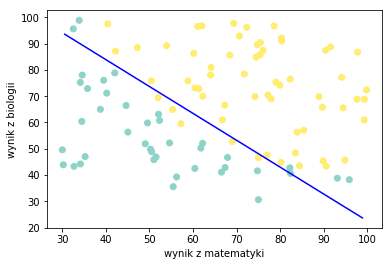

In [6]:
#Uzyskane parametry na rysunku
py.figure()
py.scatter( x[:,0], x[:,1], c=Y, cmap=py.cm.Set3)
py.xlabel('wynik z matematyki')
py.ylabel('wynik z biologii')

x_plot = np.array( [np.min(x[:,1]), np.max(x[:,1])] )
y_plot = -1. / theta_opt[2] * ( theta_opt[1] * x_plot + theta_opt[0] )
py.plot( x_plot, y_plot, 'b' )
py.show()

In [7]:
#Klasyfikacja
def klasyfikacja( X1, theta ):
  h = hipoteza_reg_log( X1, theta )
  if h > 0.5 :
    klasa = 1
  else:
    klasa = 0
  return klasa

In [8]:
#test
proba = hipoteza_reg_log(np.array([1, 20, 80]), theta_opt)
print("Dla kandydata z wynikami 20 z matematyki i 80 z biologii prawdopodobiensto przyjecia wynosi: " + str(proba))

klasa = klasyfikacja(np.array([1, 20, 80]), theta_opt)
print("Kandydat zalicza sie do klasy: " + str(klasa))

Dla kandydata z wynikami 20 z matematyki i 80 z biologii prawdopodobiensto przyjecia wynosi: 0.00725364375567
Kandydat zalicza sie do klasy: 0


In [9]:
#Walidacja
TP = 0
TN = 0
FP = 0
FN = 0

In [10]:
#Uczenie na zredukowanym zbiorze uczacym
for i in range(len(Y)):
  testX = X[i]
  testY = Y[i]
  uczX = np.delete( X, i, axis=0 )
  uczY = np.delete( Y, i )

  theta_opt = so.fmin_bfgs( minus_f_log_wiaryg, theta0, fprime=minus_pochodna_f_log_wiaryg, args=(uczX,uczY), disp = False )
  wynik = klasyfikacja( testX, theta_opt )

  if testY == 1 and wynik == 1:
     TP += 1
  if testY == 1 and wynik == 0:
     FN += 1
  if testY == 0 and wynik == 1:
     FP += 1
  if testY == 0 and wynik == 0:
     TN += 1

print('TP: ', TP)
print('FP: ', FP)
print('TN: ', TN)
print('FN: ', FN)

TP:  55
FP:  6
TN:  34
FN:  5


In [11]:
#Klasyfikacja z regulowanym progiem zdawalnosci
def klasyfikacjaProg( X1, theta, prog ):
  h = hipoteza_reg_log( X1, theta )
  if h > prog:
    klasa = 1
  else:
    klasa = 0
  return klasa

In [12]:
#Wyznaczanie krzywej ROC
def liczROC( X, Y, progi ):
  TP = np.zeros( len(progi) )
  TN = np.zeros( len(progi) )
  FP = np.zeros( len(progi) )
  FN = np.zeros( len(progi) )

  f = FloatProgress( min=0, max=len(Y) )
  display(f)

  for i in range( len(Y) ):
    f.value+=1
    #Wyznaczenie theta opt dla zredukowanych ciagow uczacych
    testX = X[i]
    testY = Y[i]
    uczX = np.delete( X, i, axis=0 )
    uczY = np.delete( Y, i )
    theta_opt = so.fmin_bfgs( minus_f_log_wiaryg, theta0, fprime=minus_pochodna_f_log_wiaryg, args=(uczX,uczY), disp = False )

    #Wyznaczenie TP, ... dla roznych progow
    for ind, prog in enumerate( progi ):
      wynik = klasyfikacjaProg( testX, theta_opt, prog )

      if testY == 1 and wynik == 1:
        TP[ind] += 1
      if testY == 1 and wynik == 0:
        FN[ind] += 1
      if testY == 0 and wynik == 1:
        FP[ind] += 1
      if testY == 0 and wynik == 0:
        TN[ind] += 1

  TPR = TP/(TP+FN)
  FPR = FP/(FP+TN)
  return ( FPR, TPR )

A Jupyter Widget

FPR:  [ 1.     0.     0.325]
TPR:  [ 1.  0.  1.]


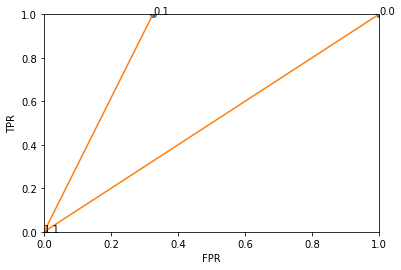

In [13]:
progi = np.array([0.0,1.1,0.1])
FPR, TPR = liczROC( X, Y, progi )
print('FPR: ', FPR)
print('TPR: ', TPR)
py.figure()
py.plot( FPR, TPR, 'o' )
py.plot( FPR, TPR )
for ind, pr in enumerate( progi ):
  py.text( FPR[ind], TPR[ind], str(pr) )
py.xlabel( 'FPR' )
py.ylabel( 'TPR' )
py.xlim( (0,1) )
py.ylim( (0,1) )
py.show()

In [14]:
AUC = 0
for i in range( len(progi) - 1 ):
  a = TPR[i]
  b = TPR[i+1]
  h = np.abs( FPR[i+1] - FPR[i] )
  print('a: ', a)
  print('b: ', b)
  print('h: ', h)
  AUC += 0.5 * (a + b) * h
print( 'BLAD!!!!!   AUC: ', AUC)

a:  1.0
b:  0.0
h:  1.0
a:  0.0
b:  1.0
h:  0.325
BLAD!!!!!   AUC:  0.6625
